In [1]:
import pandas as pd
import numpy as np
import pyarrow

In [2]:
df = pd.read_parquet("data/monitoring.parquet")
df = df.drop(columns=['file'], errors='ignore')
df

,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,actual_genre,predicted_genre
0,-322.434845,90.674240,27.020731,37.843830,19.696077,4.611148,3.071033,7.974174,1.931069,2.082464,0.440032,4.890438,13.061074,jazz,jazz
1,-237.519913,115.943642,-15.431627,47.103401,-13.503619,18.200195,-13.963651,15.332399,-17.526098,13.422287,-6.228493,8.632210,-7.249405,jazz,jazz
2,-294.054382,84.636292,39.074047,28.610291,14.117953,1.014346,7.343285,5.207617,-3.747638,-5.045502,2.226078,-0.577697,4.209762,jazz,jazz
3,-190.617630,144.019608,-28.387869,33.796574,-1.290763,-2.298157,-5.647254,-3.646698,-10.532908,-2.850047,-7.704916,-8.587104,-5.302705,jazz,jazz
4,-192.113541,105.568047,-26.025103,40.168938,-6.658171,26.505716,-10.386098,18.473986,-13.997671,14.939582,-12.698396,9.578537,-5.196664,jazz,jazz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,-180.208908,131.432449,0.600788,43.153095,14.135330,25.614765,-5.311872,12.027975,-13.535557,-1.105729,-7.616473,2.714973,0.778359,blues,blues
994,-274.376892,130.407379,-6.357460,70.388214,13.269670,9.472176,7.733095,-1.236553,-0.570986,-2.297164,3.779416,0.085482,-0.936858,blues,blues
995,-95.463570,101.387459,-20.677706,48.668915,-30.248262,20.807699,-18.291418,14.138235,-12.799490,13.443616,-14.068502,7.732349,-19.215456,blues,blues
996,-217.183640,105.785217,15.602849,25.248840,-1.450049,30.193270,-17.716623,17.319040,-27.213608,4.338282,-20.057299,-10.700287,-14.228785,blues,blues


In [3]:
accuracy = (df['actual_genre'] == df['predicted_genre']).mean()
print(f"Global Accuracy: {accuracy:.2%}")

Global Accuracy: 85.97%


In [4]:
genre_accuracy = (
    df.groupby("actual_genre")
    .apply(lambda g: (g["actual_genre"] == g["predicted_genre"]).mean())
    .sort_values(ascending=False)
)
print(genre_accuracy)

actual_genre
classical    0.980000
blues        0.950000
metal        0.900000
jazz         0.898990
pop          0.870000
country      0.870000
disco        0.820000
hiphop       0.800000
reggae       0.777778
rock         0.730000
dtype: float64


/tmp/ipykernel_99856/4249371925.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g["actual_genre"] == g["predicted_genre"]).mean())


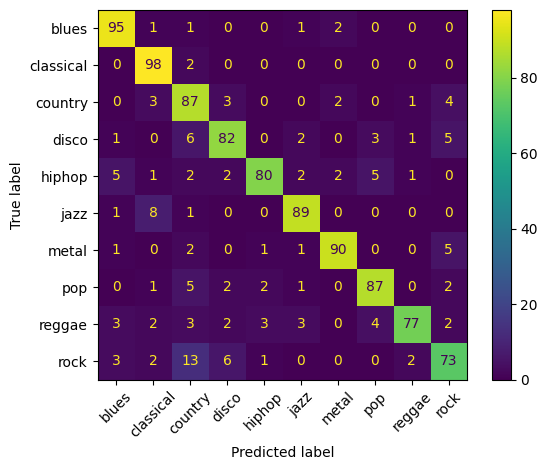

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df["actual_genre"], df["predicted_genre"], labels=sorted(df["actual_genre"].unique()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(df["actual_genre"].unique()))
disp.plot(xticks_rotation=45)

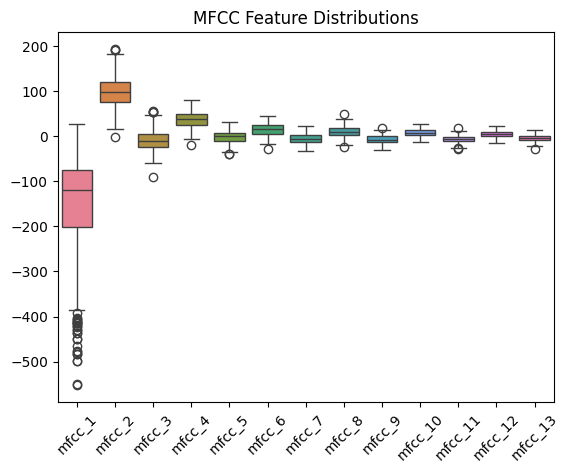

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df[[f"mfcc_{i+1}" for i in range(13)]])
plt.title("MFCC Feature Distributions")
plt.xticks(rotation=45)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Stratified split by actual_genre
reference_df, current_df = train_test_split(
    df,
    test_size=0.2,  # 20% for current, 80% for reference
    stratify=df["actual_genre"],
    random_state=42
)

# Save to Parquet
reference_df.to_parquet("data/reference.parquet", index=False)
current_df.to_parquet("data/current.parquet", index=False)

print("✅ Stratified split done:")
print(f"Reference size: {len(reference_df)} rows")
print(f"Current size: {len(current_df)} rows")


✅ Stratified split done:
Reference size: 798 rows
Current size: 200 rows


In [8]:
print("Genre distribution in reference:")
print(reference_df["actual_genre"].value_counts(normalize=True).sort_index())

print("\nGenre distribution in current:")
print(current_df["actual_genre"].value_counts(normalize=True).sort_index())

Genre distribution in reference:
actual_genre
blues        0.100251
classical    0.100251
country      0.100251
disco        0.100251
hiphop       0.100251
jazz         0.098997
metal        0.100251
pop          0.100251
reggae       0.098997
rock         0.100251
Name: proportion, dtype: float64

Genre distribution in current:
actual_genre
blues        0.1
classical    0.1
country      0.1
disco        0.1
hiphop       0.1
jazz         0.1
metal        0.1
pop          0.1
reggae       0.1
rock         0.1
Name: proportion, dtype: float64


## Evidently metrics

In [11]:
reference_df = pd.read_parquet("data/reference.parquet")
current_df = pd.read_parquet("data/current.parquet")

In [7]:
from evidently import MulticlassClassification
from evidently import Dataset
from evidently import DataDefinition
from evidently import Report
from evidently.metrics import *

In [8]:
mfcc_cols = [f"mfcc_{i+1}" for i in range(13)]

In [9]:
multiclass_definition=DataDefinition(
        numerical_columns=mfcc_cols,
        classification=[MulticlassClassification(target="actual_genre", prediction_labels="predicted_genre")],
    )

In [25]:
multiclass_definition

DataDefinition(id_column=None, timestamp=None, service_columns=None, numerical_columns=['mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13'], categorical_columns=None, text_columns=None, datetime_columns=None, classification=[MulticlassClassification(name='default', target='actual_genre', prediction_labels='predicted_genre', prediction_probas=None, labels=None)], regression=None, llm=None, numerical_descriptors=[], categorical_descriptors=[], test_descriptors=None, ranking=None)

In [12]:
multiclass_reference_data = Dataset.from_pandas(
    reference_df,
    data_definition=multiclass_definition,

)

multiclass_current_data = Dataset.from_pandas(
    current_df,
    data_definition=multiclass_definition,

)

In [13]:
metrics = [
    # Data quality metrics
    RowCount(),
    EmptyRowsCount(),
    DuplicatedRowCount(),
    *[MissingValueCount(column=col) for col in mfcc_cols],

    # Data drift metrics - check each MFCC feature for drift
    *[ValueDrift(column=col) for col in mfcc_cols],
    # Overall drift summary
    DriftedColumnsCount(columns=mfcc_cols),

    # Prediction drift (on predicted genre)
    ValueDrift(column="predicted_genre"),
    CategoryCount(
    column="predicted_genre",
    categories=sorted(reference_df["predicted_genre"].unique().tolist())
    ),

    # Classification performance
    Accuracy(),
    F1Score()
    ]

In [19]:
report = Report(metrics=metrics)
results = report.run(reference_data=multiclass_reference_data, current_data=multiclass_current_data).dict()

In [15]:
metrics_output=[]

metrics_output.append("# HELP evidently_metric Evidently monitoring metric")
metrics_output.append("# TYPE evidently_metric gauge")

for metric in results["metrics"]:
    metric_id = metric.get("metric_id").lower().replace("()", "").replace(" ", "_")
    value = metric.get("value")

    # Handle numeric values
    if isinstance(value, (int, float)):
        metrics_output.append(f"{metric_id} {value:.6f}")

    # Handle dict values (like drift counts)
    elif isinstance(value, dict):
        for sub_key, sub_val in value.items():
            if isinstance(sub_val, (int, float)):
                sub_name = f"{metric_id}_{sub_key}".replace(" ", "_").replace(",", "_")
                metrics_output.append(f"{sub_name} {sub_val:.6f}")

    # Handle numpy floats
    else:
        try:
            metrics_output.append(f"{metric_id} {float(value):.6f}")
        except:
            pass


In [16]:
metrics_output

['# HELP evidently_metric Evidently monitoring metric',
 '# TYPE evidently_metric gauge',
 'rowcount 200.000000',
 'emptyrowscount 0.000000',
 'duplicatedrowcount 0.000000',
 'missingvaluecount(column=mfcc_1)_count 0.000000',
 'missingvaluecount(column=mfcc_1)_share 0.000000',
 'missingvaluecount(column=mfcc_2)_count 0.000000',
 'missingvaluecount(column=mfcc_2)_share 0.000000',
 'missingvaluecount(column=mfcc_3)_count 0.000000',
 'missingvaluecount(column=mfcc_3)_share 0.000000',
 'missingvaluecount(column=mfcc_4)_count 0.000000',
 'missingvaluecount(column=mfcc_4)_share 0.000000',
 'missingvaluecount(column=mfcc_5)_count 0.000000',
 'missingvaluecount(column=mfcc_5)_share 0.000000',
 'missingvaluecount(column=mfcc_6)_count 0.000000',
 'missingvaluecount(column=mfcc_6)_share 0.000000',
 'missingvaluecount(column=mfcc_7)_count 0.000000',
 'missingvaluecount(column=mfcc_7)_share 0.000000',
 'missingvaluecount(column=mfcc_8)_count 0.000000',
 'missingvaluecount(column=mfcc_8)_share 0.000